# Vortex Sheet Roll-up

In [1]:
using PyPlot
using VortexModel

function plot_sheet(sheet; kwargs...)
    zs = getfield.(sheet.blobs, :z)
    plot(real.(zs), imag.(zs); kwargs...)
    axis(:scaled)
end

plot_sheet (generic function with 1 method)

We want to recreate the simulation of a vortex sheet roll-up as presented in [Krasny 1987: Computation of vortex sheet roll-up in the Trefftz plane](https://doi.org/10.1017/S0022112087002830).
The discretization parameters are listed below:

In [2]:
N = 200
α = linspace(0, π, 2N+1)
zs = complex.(cos.(α))
Γs = sin.(α)
δ = 0.05;
Δt = 0.01;

We can initialize the vortex sheet by providing it with a list of control points `zs`, the circulation from the tip of the sheet `zs[1]` to any subsequent control point, and a blob radius.

In [3]:
sheet = Vortex.Sheet(zs, Γs, δ)
w = allocate_velocity(sheet);

Unlike in [Krasny 1987](https://doi.org/10.1017/S0022112087002830), we use forward-Euler instead of 4th-order Runge-Kutta for time-marching.
This seems to work for small simulation times:

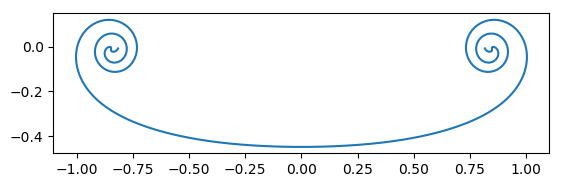

In [4]:
for t in 0.0:Δt:1.0
    reset_velocity!(w, sheet)
    self_induce_velocity!(w, sheet)
    advect!(sheet, sheet, w, Δt)
end
plot_sheet(sheet);

But over a longer period, instabilities in the sheet start to show

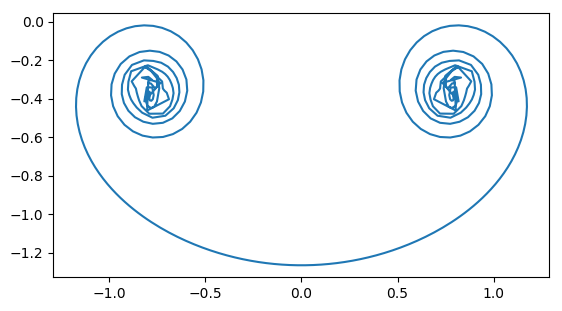

In [5]:
for t in 1.01:Δt:4.0
    reset_velocity!(w, sheet)
    self_induce_velocity!(w, sheet)
    advect!(sheet, sheet, w, Δt)
end
plot_sheet(sheet);

One way we can supress the instabilities is to directly filter out any length scales in the sheet below a specified threshold.

In [6]:
function filter_sheet!(sheet, Δs, Δf)
    zs = Vortex.position.(sheet.blobs)
    zs, (Γs,) = Vortex.Sheets.filter_by_arclength(zs, Δs, Δf, sheet.Γs)
    Vortex.Sheets.remesh!(sheet, zs, Γs)
end

filter_sheet! (generic function with 1 method)

Here, we will remove any distrubances along the sheet with length scales smaller than the blob radius.

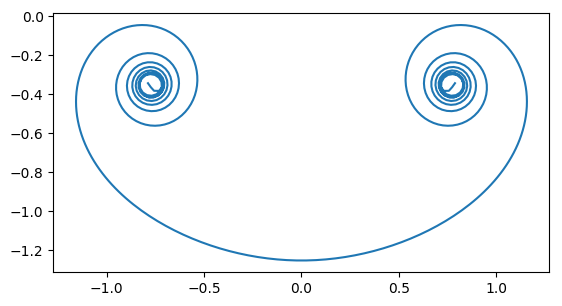

In [7]:
sheet = Vortex.Sheet(zs, Γs, δ)

for t in 0:Δt:4.0
    reset_velocity!(w, sheet)
    self_induce_velocity!(w, sheet)
    advect!(sheet, sheet, w, Δt)
    filter_sheet!(sheet, 0.5δ, δ)
end
plot_sheet(sheet);